# MF728 Project: Estimating the Yield Curve Using Three models


我还是用了国内数据。因为实在不会从价格里面提取spot rate，就直接用了现成的rate。然后因为有个组做的和我们几乎一样，使用美国treasury rate的，为了不重复，我就还是用了国内数据。不保证都是对的，但好歹有个结果。最终结果有点奇怪的话，kris应该不熟悉中国市场，可以瞎逼逼。 \
其他思路就和上交那篇论文比较像，用模型拟合出结果。然后参考了其他几篇文章的分析方法，算了Rsquare， 并对画了3D图。 最后用模型去给交易日的债券定价算价差。\
还有一点问题，就是用nelson这个包算NSSmodel的时候，他包自己的问题，很难优化tau1 和 tau2， 导致他们一直是恒定的，你们在后面可以看到。现在让我自己写程序去弄NSS我肯定不行了，你们想想看怎么解释. 但这个模型表现效果还是可以的\
然后就是B样条，我看上交论文里面是有模型系数的，但我只是调用包，不会弄，你们会弄的可以补充。\

我有些地方做了注释和小分析，不保证是对的，但肯定不够，大家请继续深入分析。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

In [2]:
sr = pd.read_csv('spot_rate.csv',index_col = 'Date')/100 
# This spot rate data comes from China Banking and Insurance Regulatory Commission.
# https://www.cbirc.gov.cn/cn/view/pages/index/guozhai.html

# At first we planed to use the daily trading prices of bonds to extract the spot rate.
# However, due to the lack of key maturity and the liquidity of China market data, and also we fail to do design the algrithem.SO we give up.
# We think it still work use the official existing spot rate data.

In [3]:
sr

,3m,6m,1y,3y,5y,7y,10y,30y
Date,,,,,,,,
2018/1/2,0.037797,0.037725,0.036767,0.037786,0.038262,0.039000,0.039008,0.043723
2018/1/3,0.036554,0.037176,0.036667,0.037426,0.038503,0.039006,0.039162,0.043723
2018/1/4,0.035140,0.035774,0.035968,0.037496,0.038804,0.039104,0.039319,0.043723
2018/1/5,0.034058,0.035255,0.035392,0.037164,0.038484,0.039057,0.039212,0.043623
2018/1/8,0.032977,0.035149,0.035336,0.036771,0.038257,0.039005,0.039110,0.043524
...,...,...,...,...,...,...,...,...
2022/4/20,0.018585,0.019654,0.020136,0.024088,0.025862,0.028450,0.028330,0.033202
2022/4/21,0.018610,0.019528,0.019825,0.023989,0.025788,0.028450,0.028259,0.033052
2022/4/22,0.018815,0.019493,0.019542,0.024202,0.026018,0.028600,0.028409,0.033077


<AxesSubplot:xlabel='Date'>

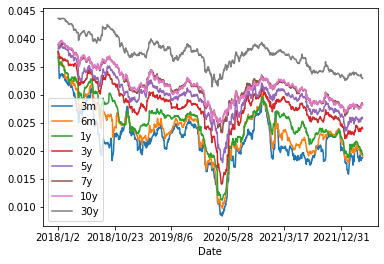

In [4]:
sr.plot() # a brief view of the tendency of these spot rates during the 4 years.
# we can see that around 2020/4, there's a drop in the rates.

## 1.vertical comparison
### 1.1 Neslon-Siegel Model

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, errorfn_ns_ols

Here we use the package of nelson_siegel_svensson to help us calibrate.\
'calibrate_ns_ols' use the OLS  to calibrate the model, we input the maturities and rate list, then it out put a model. While the 'errorfn_ns_ols' give us the residual error of that linear model

In [6]:
# In this cell we calibrate the parameters of NS model for each day.
t = np.array([3/12, 6/12, 1.0, 3.0, 5.0,7.0, 10.0, 30.0])
yields_NS = sr.values

fitted_NS = []
b0lst = []
b1lst = []
b2lst = []
taulst = []
R2lst = []
for date in sr.index:
    y = sr.loc[date].values
    curve, status = calibrate_ns_ols(t, y, tau0=0.1)
    assert status.success
    dic = vars(curve)
    beta0 = dic['beta0'] # extract the params from model
    beta1 = dic['beta1']
    beta2 = dic['beta2']
    tau = dic['tau']
    ssr = errorfn_ns_ols(tau,t,y) # compute the error of residul from the model with optimal tau
    R2 = 1 - ssr/sum(np.square(y-y.mean())) # calculate the Coefficient of determination
    b0lst += [beta0]
    b1lst += [beta1]
    b2lst += [beta2]
    taulst += [tau]
    R2lst += [R2]
    fitted_NS.append(curve(t).tolist())
coefNS = pd.DataFrame({'beta0':b0lst,'beta1':b1lst,'beta2':b2lst,'tau':taulst,'R2':R2lst},sr.index)
fitted_NS = np.array(fitted_NS)

In [7]:
coefNS

,beta0,beta1,beta2,tau,R2
Date,,,,,
2018/1/2,0.044055,-0.005534,-0.014602,1.839243,0.885066
2018/1/3,0.043682,-0.006066,-0.013290,1.624391,0.890106
2018/1/4,0.042782,-0.006594,-0.012030,1.098828,0.886259
2018/1/5,0.042730,-0.007597,-0.011459,1.114913,0.903023
2018/1/8,0.042619,-0.008343,-0.010116,1.163974,0.891890
...,...,...,...,...,...
2022/4/20,0.032880,-0.013312,-0.017957,1.022071,0.970939
2022/4/21,0.032751,-0.013039,-0.019186,0.976733,0.972271
2022/4/22,0.032741,-0.012611,-0.021056,0.894673,0.974199


In [8]:
coefNS['R2'].mean()
# The mean of its R2 is not bad.

0.938616782636803

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_39796/2706863363.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


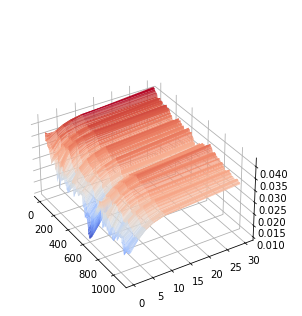

In [9]:
# In this cell we plot the our model for each day.
fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(1, 1079)
y = t
X, Y = np.meshgrid(x, y)
Z = fitted_NS.T
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = plt.get_cmap("coolwarm"))
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.7, 1]))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(32, -32)
plt.show()

### 1.2 Nelson-Siegel-Svensson

In [10]:
from nelson_siegel_svensson.calibrate import calibrate_nss_ols, errorfn_nss_ols

we do the same thing as above

In [11]:
t = np.array([3/12, 6/12, 1.0, 3.0, 5.0,7.0, 10.0, 30.0])
yields_NSS = sr.values

fitted_NSS = []
b0lst = []
b1lst = []
b2lst = []
b3lst = []
tau1lst = []
tau2lst = []
R2lst = []
for date in sr.index:
    y = sr.loc[date].values
    curve, status = calibrate_nss_ols(t, y,[2,5]) # Here we set tau1=2, tau2 =5, for it's not work well for us to do the optimize algrithem.
    assert status.success
    dic = vars(curve)
    beta0 = dic['beta0'] # extract the params from model
    beta1 = dic['beta1']
    beta2 = dic['beta2']
    beta3 = dic['beta3']
    tau1 = dic['tau1']
    tau2 = dic['tau2']
    tau0 = (tau1,tau2)
    ssr = errorfn_nss_ols(tau0,t,y) #compute the error of residul from the model with optimal tau
    R2 = 1 - ssr/sum(np.square(y-y.mean())) # calculate the Coefficient of determination
    b0lst += [beta0]
    b1lst += [beta1]
    b2lst += [beta2]
    b3lst += [beta3]
    tau1lst += [tau1]
    tau2lst += [tau2]
    R2lst += [R2]
    fitted_NSS.append(curve(t).tolist())
coefNSS = pd.DataFrame({'beta0':b0lst,'beta1':b1lst,'beta2':b2lst,'beta3':b3lst,'tau1':tau1lst,'tau2':tau2lst,'R2':R2lst},sr.index)
fitted_NSS = np.array(fitted_NSS)

In [12]:
coefNSS

,beta0,beta1,beta2,beta3,tau1,tau2,R2
Date,,,,,,,
2018/1/2,0.047482,-0.009877,-0.003704,-0.017850,2.0,5.0,0.967001
2018/1/3,0.047552,-0.011024,-0.001381,-0.018644,2.0,5.0,0.982421
2018/1/4,0.047632,-0.012953,0.003020,-0.020116,2.0,5.0,0.991286
2018/1/5,0.047571,-0.013843,0.003895,-0.020296,2.0,5.0,0.990168
2018/1/8,0.047677,-0.014642,0.005462,-0.021730,2.0,5.0,0.975666
...,...,...,...,...,...,...,...
2022/4/20,0.036358,-0.018503,-0.001228,-0.011653,2.0,5.0,0.991074
2022/4/21,0.035928,-0.018105,-0.002385,-0.009710,2.0,5.0,0.989370
2022/4/22,0.035651,-0.017804,-0.003060,-0.007810,2.0,5.0,0.986955


In [13]:
coefNSS['R2'].mean()
# Here we find that NSS model has higher R2, it works better in statistics.

0.9869084587540983

/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_39796/3000388194.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


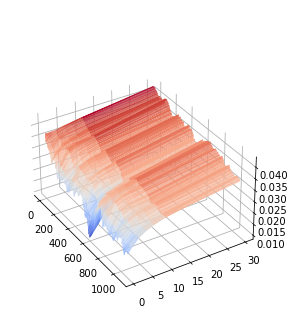

In [14]:
fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(1, 1079)
y = t
X, Y = np.meshgrid(x, y)
Z = fitted_NSS.T
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = plt.get_cmap("coolwarm"))
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.7, 1]))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(32, -32)
plt.show()

In [15]:
fitted_NSS.T

array([[0.03755331, 0.03665921, 0.03514361, ..., 0.0185499 , 0.01841993,
        0.01830787],
       [0.03751575, 0.03677958, 0.03555057, ..., 0.01920834, 0.01910891,
        0.01895456],
       [0.03747791, 0.03699435, 0.03622151, ..., 0.02040408, 0.0203502 ,
        0.02013338],
       ...,
       [0.03862715, 0.03872078, 0.03892389, ..., 0.02768545, 0.02764448,
        0.02743961],
       [0.03950814, 0.03955977, 0.0396642 , ..., 0.02920756, 0.02913542,
        0.02899218],
       [0.04365352, 0.04367159, 0.04367545, ..., 0.03298116, 0.03290633,
        0.0328502 ]])

### 1.3 Spline

In [16]:
from scipy import interpolate

In [17]:
yiled = sr.values
fitted_sp = []

for date in sr.index:
    y = sr.loc[date].values
    t = np.array([3/12, 6/12, 1.0, 3.0, 5.0,7.0, 10.0, 30.0])
    spl = interpolate.UnivariateSpline(t, y)
    fitted_sp.append(spl(np.arange(0,30,0.1)).tolist())
    
fitted_sp = np.array(fitted_sp)
  


/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_39796/3005784926.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


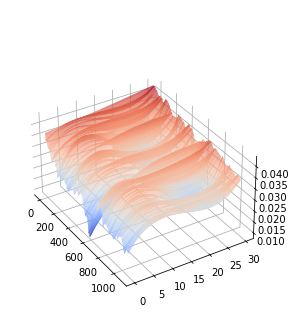

In [18]:
fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(1, 1079)
y = np.arange(0,30,0.1)
X, Y = np.meshgrid(x, y)
Z = fitted_sp.T
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = plt.get_cmap("coolwarm"))
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.7, 1]))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(32, -32)
plt.show()

## 2. horizontal comparison

In [19]:
def someday(date):
    """this function input a certain date in our dataframe
    and output the plot of three curves derived from each model at that date.
    """
    df = sr.loc[date]
    y = df.values
    t = np.array([3/12, 6/12, 1.0, 3.0, 5.0,7.0, 10.0, 30.0])
    curveNS, status = calibrate_ns_ols(t, y, tau0=0.1)
    assert status.success
    curveNSS, status = calibrate_ns_ols(t, y)
    assert status.success
    curvesp = interpolate.UnivariateSpline(t, y)
    
    T = np.arange(0,30,0.1)
    plt.xlabel('Maturity')
    plt.ylabel('Spot Rate')
    plt.plot(t, y, "bo",label='Real Rate')
    plt.plot(T, curveNS(T), "r",label='NS Model')
    plt.plot(T, curveNSS(T), "y",label='NSS Model')
    plt.plot(T, curvesp(T), "g",label='Spline')
    plt.legend()

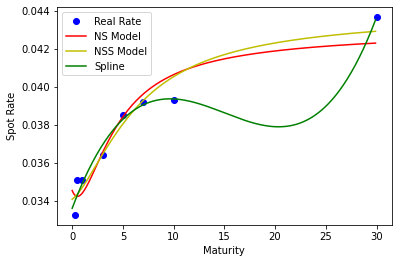

In [20]:
someday('2018/1/30')

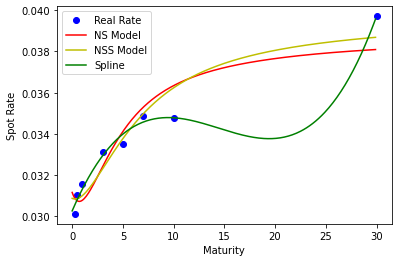

In [21]:
someday('2018/6/29')

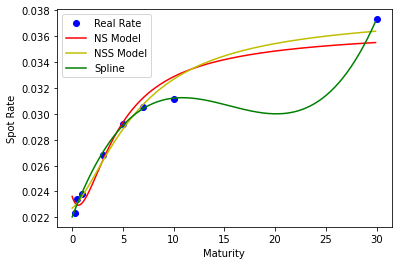

In [22]:
someday('2019/1/30')

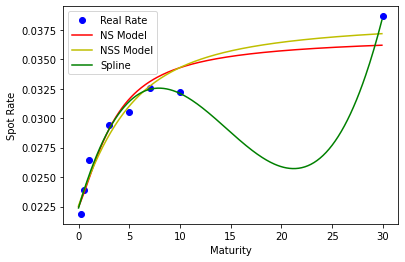

In [23]:
someday('2019/6/28')

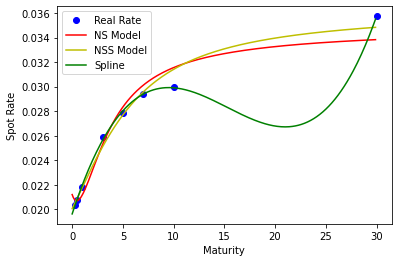

In [24]:
someday('2020/1/23')

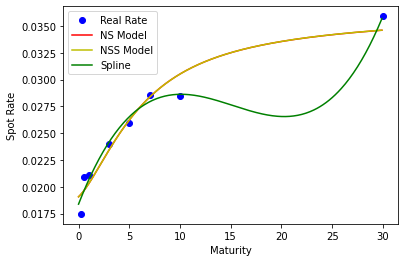

In [25]:
someday('2020/6/29') # NS and NSS overlap

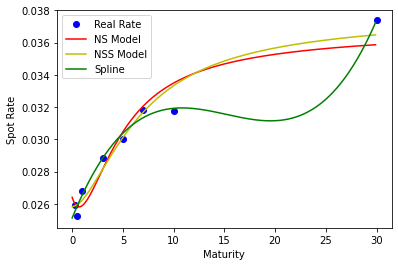

In [26]:
someday('2021/1/29')

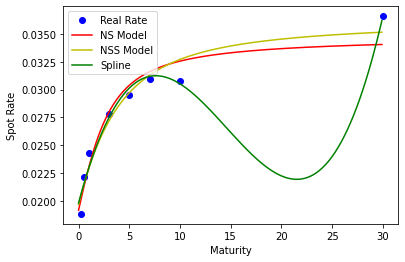

In [27]:
someday('2021/6/30')

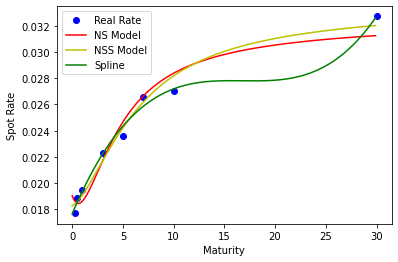

In [28]:
someday('2022/1/30')

We find that NS model and NSS model have some similar performance, however the spline curve have some anomaly from 10 to 30. I think that might because the lack of data in these maturities. Actually, Chinese market is not liquid as US market, especially the medium term.

## 3. Empirical Study

In [29]:
data = pd.read_csv('data.csv',index_col = 'Date')

In [30]:
data

,ticker,Name,Par,CoupRt,Freq,Maturity,YrsTMat,Close Price
Date,,,,,,,,
2018/1/31,G170009,17附息国债09,100,3.32,0,1,0.254795,100.00
2018/1/31,G170017,17附息国债17,100,3.33,0,1,0.504110,99.90
2018/1/31,G170024,17附息国债24,100,3.54,0,1,0.753425,100.00
2018/1/31,G170007,17附息国债07,100,3.13,1,5,4.197260,96.68
2018/1/31,G170014,17附息国债14,100,3.47,1,5,4.446575,97.95
...,...,...,...,...,...,...,...,...
2022/3/31,G170015,17附息国债15,100,4.05,2,30,25.315068,110.92
2022/3/31,G180017,18附息国债17,100,3.97,2,30,26.313541,109.01
2022/3/31,G190010,19附息国债10,100,3.86,2,30,27.309589,107.80


This dataset is collected from Shanghai Stock Exchange in Resset Database. we only focus on the fixed-rate Chinese treasury bonds in this project.  
China's bond market is less active than US, lots of bonds might not be traded everyday. So I picked the day when the most bonds were traded in a certain month from 2018 to 2022. 
For example we can choose one date to have a brief view of these data.

In [31]:
data.loc['2018/1/31']

,ticker,Name,Par,CoupRt,Freq,Maturity,YrsTMat,Close Price
Date,,,,,,,,
2018/1/31,G170009,17附息国债09,100,3.32,0,1,0.254795,100.00
2018/1/31,G170017,17附息国债17,100,3.33,0,1,0.504110,99.90
2018/1/31,G170024,17附息国债24,100,3.54,0,1,0.753425,100.00
2018/1/31,G170007,17附息国债07,100,3.13,1,5,4.197260,96.68
2018/1/31,G170014,17附息国债14,100,3.47,1,5,4.446575,97.95
2018/1/31,G170010,17附息国债10,100,3.52,2,10,9.254795,96.00
2018/1/31,G170018,17附息国债18,100,3.59,2,10,9.504110,96.80
2018/1/31,G170025,17附息国债25,100,3.82,2,10,9.753425,98.93
2018/1/31,G170015,17附息国债15,100,4.05,2,30,29.476712,94.69


The important colmuns might be the years to maturity, coupon rate and close price. From the 'years to maturity' we can see it's true that China has less medium term bonds in trading, which we have mentioned before.

In [32]:
def compute_price_spread(dd,method='NS'):
    """This function compute the price spread list for a certain date.
       Input a dataframe of that date and choose the method.
       then return a list of theorical price and the price spread between theortical price and close price.
    """
    date = dd.index[0]
    df = sr.loc[date]
    y = df.values
    t = np.array([3/12, 6/12, 1.0, 3.0, 5.0,7.0, 10.0, 30.0])
    plst = []
    spread = []
    if method == 'NS':
        curve, status = calibrate_ns_ols(t, y, tau0=0.1)
    elif method == 'NSS':
        curve, status = calibrate_nss_ols(t, y)
    elif method == 'spline':
        curve = interpolate.UnivariateSpline(t, y)
        
    def compute_price(coup,t,rate):
        # this function compute the bond price, just for convinence
        return coup/(1+rate)**(t-int(t)) * ((1-(1/(1+rate)**int(t)))/(1-1/(1+rate))) + (coup+100)/(1+rate)**t
    
    for i in range(len(dd)):
        if dd['Freq'][i] == 0:
            price = dd['Par'][i] / (1+curve(dd['YrsTMat'][i]))**dd['YrsTMat'][i]
            diff = dd['Close Price'][i] - price
        elif dd['Freq'][i] == 1 :
            price = compute_price(dd['CoupRt'][i],dd['YrsTMat'][i],curve(dd['YrsTMat'][i]))
            diff = dd['Close Price'][i] - price
            #price = dd['CoupRt'][i]/(1+curve(dd['YrsTMat'][i]))**(dd['YrsTMat'][i]-int(dd['YrsTMat'][i])) * ((1-(1/(1+curve(dd['YrsTMat'][i]))**int(dd['YrsTMat'][i])))/(1-1/(1+curve(dd['YrsTMat'][i])))) + (dd['CoupRt'][i]+100)/(1+curve(dd['YrsTMat'][i]))**dd['YrsTMat'][i]
        if dd['Freq'][i] == 2:
            price = compute_price(dd['CoupRt'][i]/2,dd['YrsTMat'][i]*2,curve(dd['YrsTMat'][i])/2)
            diff = dd['Close Price'][i] - price
        plst += [price]
        spread += [diff]
    return plst, spread
    

First, we use 2018/1/31 as example

In [33]:
def dayspread(dd):
    """This function shows the price spreads of each bond on a given date, calculated using different models
    """
    NSprice,NSspread = compute_price_spread(dd,method='NS')
    NSSprice,NSSspread = compute_price_spread(dd,method='NSS')
    spprice,spspread = compute_price_spread(dd,method='spline')
    
    dd2 = dd.drop(columns={'Name','Par','CoupRt','Freq','Maturity','YrsTMat','Close Price'})
    dd2['SpreadPrice-NS'] = NSspread
    dd2['SpreadPrice-NSS']= NSSspread
    dd2['SpreadPrice-spline'] = spspread
    
    return dd2
    
    

In [34]:
dd = data.loc['2018/1/31']
dspread = dayspread(dd)
dspread

,ticker,SpreadPrice-NS,SpreadPrice-NSS,SpreadPrice-spline
Date,,,,
2018/1/31,G170009,0.855617,0.843586,0.844981
2018/1/31,G170017,1.577713,1.581935,1.580457
2018/1/31,G170024,2.495621,2.529862,2.523282
2018/1/31,G170007,-3.423834,-3.450455,-3.395247
2018/1/31,G170014,-2.701605,-2.771134,-2.700911
2018/1/31,G170010,-0.905667,-1.610184,-1.740429
2018/1/31,G170018,-1.432960,-2.149983,-2.334593
2018/1/31,G170025,-0.169073,-0.902099,-1.148607
2018/1/31,G170015,-2.472786,-0.399016,-1.307054


Similarly, we can use this function to see the price spread of other date and we can also see some statistics

In [35]:
print(dspread.mean())
print(dspread.std())

SpreadPrice-NS       -0.686330
SpreadPrice-NSS      -0.703054
SpreadPrice-spline   -0.853125
dtype: float64
SpreadPrice-NS        2.038630
SpreadPrice-NSS       2.029123
SpreadPrice-spline    2.042000
dtype: float64


/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_39796/3253463240.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(dspread.mean())
/var/folders/jp/bc6syfnn06nd5vh0zytf1ry80000gn/T/ipykernel_39796/3253463240.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(dspread.std())


Then we implement a loop to see the whole picture of our data

In [36]:
def showallspread():
    df = pd.DataFrame(columns=['ticker','SpreadPrice-NS','SpreadPrice-NSS','SpreadPrice-spline'])
    df.index.name = 'Date'
    for dates in data.index:
        dd = data.loc[dates]
        dsp = dayspread(dd)
        dfs = [df,dsp]
        df = pd.concat(dfs)
        
    return df  

In [37]:
allprice = showallspread()

In [38]:
allprice = allprice.drop(columns='ticker')

In [39]:
absprice = abs(allprice) # we use the absolute value to see their performance.

In [40]:
means = absprice.groupby('Date').mean()
means

,SpreadPrice-NS,SpreadPrice-NSS,SpreadPrice-spline
Date,,,
2018/1/31,1.781653,1.804251,1.952840
2018/10/31,2.560957,1.210975,2.840116
2018/11/27,2.827282,1.946008,3.069956
2018/12/28,3.429950,1.955615,2.271922
2018/2/28,2.377565,1.988038,2.191869
2018/3/30,2.137444,1.403718,1.952285
2018/4/20,1.678551,1.249542,1.887547
2018/5/30,1.322970,1.096501,1.452125
2018/6/29,1.876675,1.925957,2.193700


In [41]:
means.mean()

SpreadPrice-NS        2.714842
SpreadPrice-NSS       1.590901
SpreadPrice-spline    8.782095
dtype: float64

In [42]:
means.std()

SpreadPrice-NS        0.679538
SpreadPrice-NSS       0.305405
SpreadPrice-spline    6.522288
dtype: float64

We can see that the price spread of spline model is really unstable. There might be some reasons, for example the sport rate we use lack the medium term structure, leading to abnormal value in spline model.


For NS and NSS model, just from the mean of its price spread we can see that NSS performed better in China market. It also fitts our result in statistic before.